In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

In [28]:
df = pd.read_csv('synthetic_flights_small.csv')

In [29]:
# Feature Engineering
df['pushback_time'] = pd.to_datetime(df['pushback_time'])
df['takeoff_time'] = pd.to_datetime(df['takeoff_time'])
df['pushback_hours'] = df['pushback_time'].dt.hour
df['day_of_week'] = df['pushback_time'].dt.dayofweek

df['rush_hour'] = df['pushback_hours'].isin([7,8,9,16,17,18]).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['visibility_cat'] = pd.cut(df['visibility_km_at_push'],
                              bins=[-1,3,6,10], labels=['Low','Medium','High'])
df['wind_cat'] = pd.cut(df['wind_spd_kt_at_push'],
                        bins=[-1, 5, 15, 30], labels=['Calm', 'Moderate', 'Strong'])

In [30]:
# Additional features
df['wind_visibility_interaction'] = df['wind_spd_kt_at_push'] / (df['visibility_km_at_push'] + 1)
df['hour_sin'] = np.sin(2 * np.pi * df['pushback_hours'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['pushback_hours'] / 24)
df['has_delay'] = df['delay_reason'].notna().astype(int)
df['delay_type'] = df['delay_reason'].fillna('None')

In [31]:
feature_num = [
    "queue_len", "wind_spd_kt_at_push", "visibility_km_at_push",
    "pushback_hours", "day_of_week", "rush_hour", "is_weekend",
    "wind_visibility_interaction", "hour_sin", "hour_cos", "has_delay"
]
feature_cat = [
    "airline", "aircraft_type", "runway", "visibility_cat", "wind_cat", "delay_type"
]

X = df[feature_num + feature_cat]
y = df["taxi_out_min"]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
preprocessor = ColumnTransformer([
    ("num", "passthrough", feature_num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cat)
])

In [34]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

In [35]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds) ** 0.5
r2 = r2_score(y_test, preds)
cv_mae = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error").mean()

print("BEST MODEL: BASELINE GRADIENTBOOSTING")
print("="*50)
print(f"MAE: {mae:.3f} minutes")
print(f"RMSE: {rmse:.3f} minutes")
print(f"R²: {r2:.3f}")
print(f"CV MAE: {cv_mae:.3f} minutes")

BEST MODEL: BASELINE GRADIENTBOOSTING
MAE: 4.436 minutes
RMSE: 5.599 minutes
R²: 0.714
CV MAE: 4.680 minutes


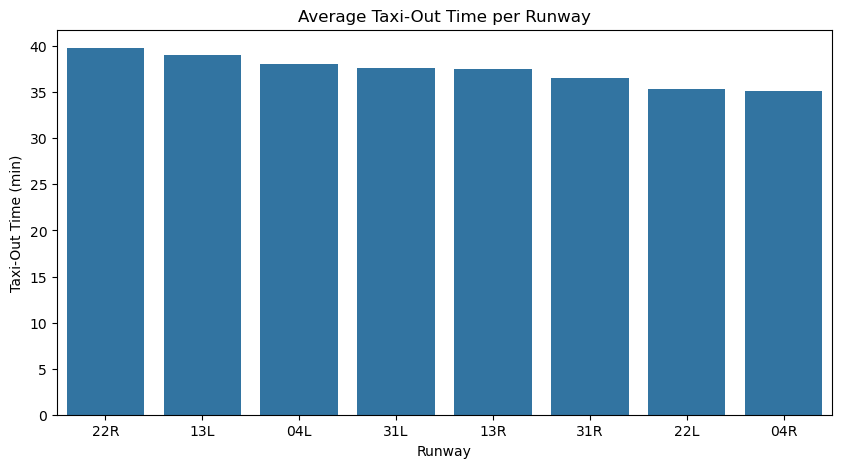

In [36]:
plt.figure(figsize=(10,5))
runway_avg = df.groupby('runway')['taxi_out_min'].mean().sort_values(ascending=False)
sns.barplot(x=runway_avg.index, y=runway_avg.values)
plt.title('Average Taxi-Out Time per Runway')
plt.ylabel('Taxi-Out Time (min)')
plt.xlabel('Runway')
plt.show()

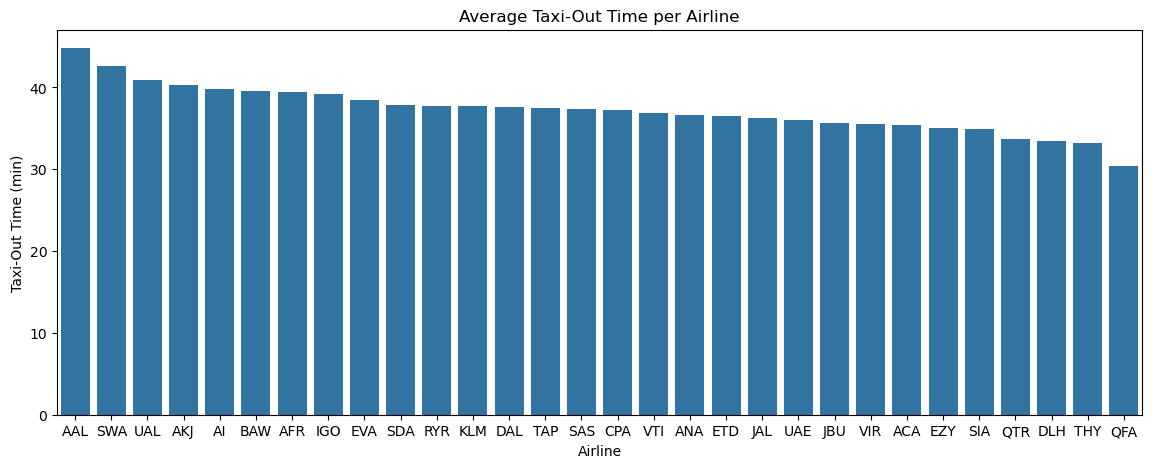

In [37]:
plt.figure(figsize=(14,5))
airline_avg = df.groupby('airline')['taxi_out_min'].mean().sort_values(ascending=False)
sns.barplot(x=airline_avg.index, y=airline_avg.values)
plt.title('Average Taxi-Out Time per Airline')
plt.ylabel('Taxi-Out Time (min)')
plt.xlabel('Airline')
plt.show()

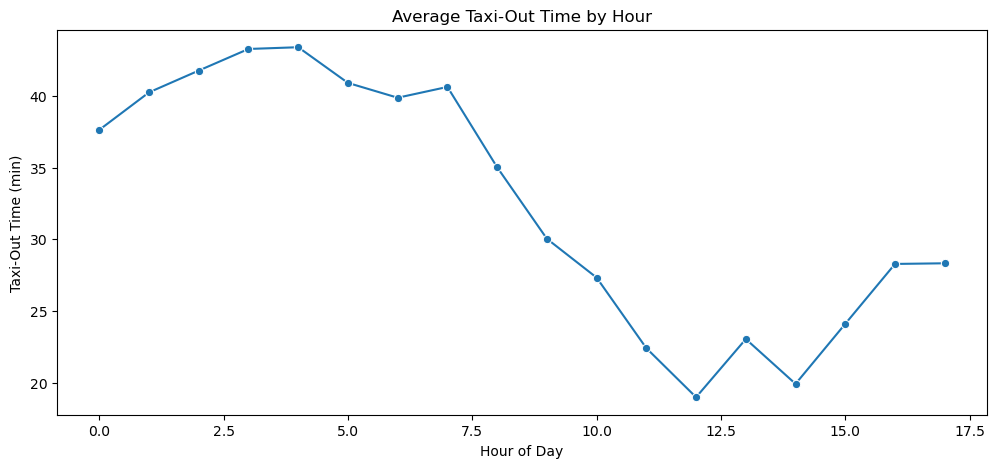

In [38]:
plt.figure(figsize=(12,5))
hour_avg = df.groupby('pushback_hours')['taxi_out_min'].mean()
sns.lineplot(x=hour_avg.index, y=hour_avg.values, marker='o')
plt.title('Average Taxi-Out Time by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Taxi-Out Time (min)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11696\2944736116.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vis_avg = df.groupby('visibility_cat')['taxi_out_min'].mean()


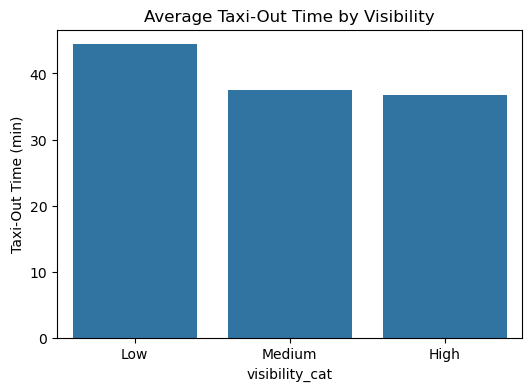

In [39]:
#  Weather Impact Analysis

df['visibility_cat'] = pd.cut(df['visibility_km_at_push'], bins=[-1,3,6,10], labels=['Low','Medium','High'])
vis_avg = df.groupby('visibility_cat')['taxi_out_min'].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=vis_avg.index, y=vis_avg.values)
plt.title('Average Taxi-Out Time by Visibility')
plt.ylabel('Taxi-Out Time (min)')
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11696\2895206599.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_avg = df.groupby('wind_cat')['taxi_out_min'].mean()


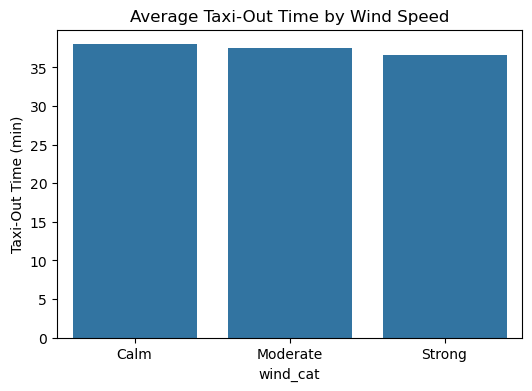

In [40]:
# Wind categories
df['wind_cat'] = pd.cut(df['wind_spd_kt_at_push'], bins=[-1,5,15,30], labels=['Calm','Moderate','Strong'])
wind_avg = df.groupby('wind_cat')['taxi_out_min'].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=wind_avg.index, y=wind_avg.values)
plt.title('Average Taxi-Out Time by Wind Speed')
plt.ylabel('Taxi-Out Time (min)')
plt.show()

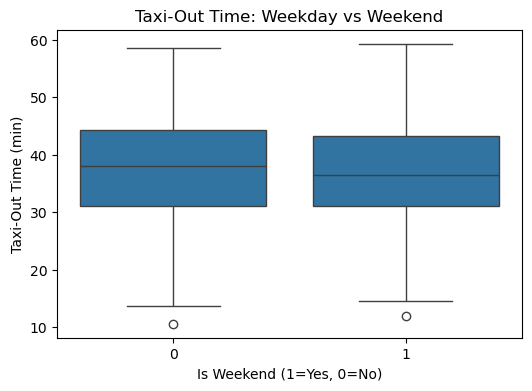

In [41]:
plt.figure(figsize=(6,4))
sns.boxplot(x='is_weekend', y='taxi_out_min', data=df)
plt.title('Taxi-Out Time: Weekday vs Weekend')
plt.xlabel('Is Weekend (1=Yes, 0=No)')
plt.ylabel('Taxi-Out Time (min)')
plt.show()